In [1]:
import os
import pandas as pd
import upsetplot
from functools import reduce
from itertools import combinations
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages


In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return

In [3]:
meta_file = "../data/meta_activity_map.csv"
ko_lines = ["ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]
meta_df = pd.read_csv(meta_file)


In [4]:
def get_coord_per_lib(meta_df, lib):
    gained_query = f"(`CC_peak`==0) & (`{lib}_peak`==1) & (`{lib}_log2FoldChange`>0) & (`{lib}_padj`<0.01)"
    lost_query = f"(`CC_peak`==1) & (`{lib}_peak`==0) & (`{lib}_log2FoldChange`<0) & (`{lib}_padj`<0.01)"
    gained_fragments = set(meta_df.query(gained_query).chrom_coord.values)
    lost_fragments = set(meta_df.query(lost_query).chrom_coord.values)
    return gained_fragments, lost_fragments


def set_add(a, b):
    return a.intersection(b)

def set_subtract(a,b):
    return a.difference(b)

def get_intersects(include_sets, exclude_sets):
    intersect_sets = reduce(set_add, include_sets)
    if len(exclude_sets)>0:
        exclude_sets = [intersect_sets] + exclude_sets
        intersect_sets = reduce(set_subtract, exclude_sets)
    return intersect_sets

def get_upset_df(groups, elements):
    # get the set of gene combinations for each group
    combo_dict = dict(zip(groups, elements))
    combo_boolean_dict = {g:[] for g in groups}
    counts = []
    unique_intersect_sets = dict()
    for i in range(1, len(groups) + 1):
        # get combinations of length i
        all_combos = list(combinations(groups, i))
        for combos in all_combos:
            # get counts of elements that are unique to the combinations
            include_combos = combos
            exclude_combos = tuple(g for g in groups if g not in include_combos)
            include_sets = [combo_dict[c] for c in include_combos]
            exclude_sets = [combo_dict[c] for c in exclude_combos]
            unique_intersects = get_intersects(include_sets, exclude_sets)
            counts.append(len(unique_intersects))
            unique_intersect_sets[(include_combos, exclude_combos)] = unique_intersects
            for c in include_combos:
                combo_boolean_dict[c].append(True)
            for c in exclude_combos:
                combo_boolean_dict[c].append(False)
    combo_boolean_dict["counts"] = counts
    df = pd.DataFrame(combo_boolean_dict)
    return df.set_index(groups), unique_intersect_sets


# Gained fragments

In [5]:
upset_df, unique_intersects = get_upset_df(ko_lines, [get_coord_per_lib(meta_df, lib)[0] for lib in ko_lines])

(0.0, 1.0, 0.0, 1.0)

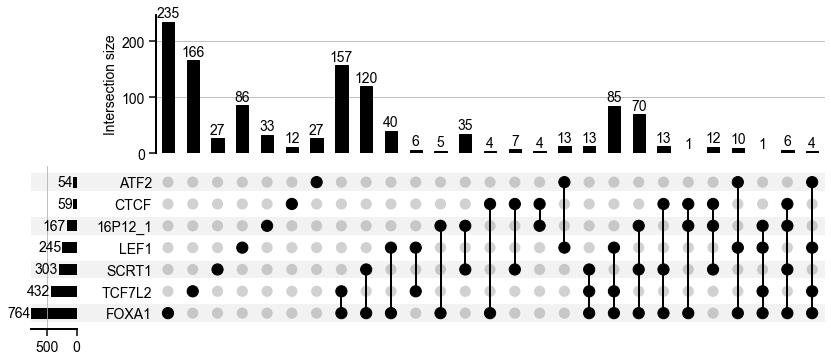

In [6]:
parsed_upset_df = upset_df.loc[upset_df.counts>0]

fig,ax = plt.subplots(1,1)
upsetplot.plot(parsed_upset_df.counts, show_counts=True, fig=fig)
ax.axis("off")

In [7]:
save_file = "/data5/deepro/starrseq/papers/results/2_categorize_fragments_on_activity/data/figures/gained_all.pdf"
save_pdf(save_file, fig)

# Lost fragments

In [8]:
upset_df, unique_intersects = get_upset_df(ko_lines, [get_coord_per_lib(meta_df, lib)[1] for lib in ko_lines])

(0.0, 1.0, 0.0, 1.0)

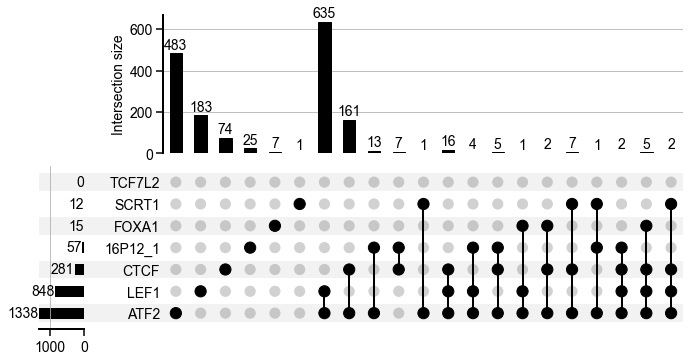

In [9]:
parsed_upset_df = upset_df.loc[upset_df.counts>0]

fig,ax = plt.subplots(1,1)
upsetplot.plot(parsed_upset_df.counts, show_counts=True, fig=fig)
ax.axis("off")

In [10]:
save_file = "/data5/deepro/starrseq/papers/results/2_categorize_fragments_on_activity/data/figures/lost_all.pdf"
save_pdf(save_file, fig)

In [11]:
gained_query = "(`CC_peak`==0) & (" + "|".join([f"(`{ko}_peak`==1 & `{ko}_padj`<0.01 & `{ko}_log2FoldChange`>0)" for ko in ko_lines]) + ")"
lost_query = "(`CC_peak`==1) & (" + "|".join([f"(`{ko}_peak`==0 & `{ko}_padj`<0.01 & `{ko}_log2FoldChange`<0)" for ko in ko_lines]) + ")"

In [12]:
len(meta_df) - 2376, len(meta_df.query(gained_query)), len(meta_df.query(lost_query))

(251256, 1192, 1635)